# Curso de Capacitación en Machine Learning para la Industria (ML CETAM) - Sesión 6 (Tarea)

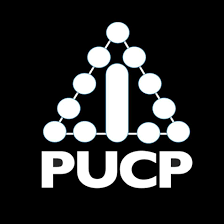
<img src='https://dci.pucp.edu.pe/wp-content/uploads/2014/02/logo-color-pucp1.gif' width=200px>


PhD. Edwin Villanueva, PhD. Soledad Espezua, BSc. Daniel Saromo

<font color='#008B72'> Modelos ensamblados: Predicción de la calidad en la industria vinícola </font>

## Caso: Determinación de la calidad de vinos

Fuente del dataset: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

Enlace de descarga del dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

<img src='https://miro.medium.com/max/3840/1*2ayKmvVZCYaLPl-nmLLp5g.png' width=180px>

En la industria vinícola, una etapa importante consiste en la determinación de la calidad del vino elaborado. Este etiquetado es realizado por catadores profesionales, quienes prueban el vino y dan su veredicto. El presente dataset contiene información de características físicas (medibles) del vino, así como de la calidad indicada por catadores profesionales.

**Información de los atributos:**

Se tienen los siguientes atributos:

- Fixed acidity
- Volatile acidity
- Citric acid
- Residual sugar
- Chlorides
- Free sulfur dioxide
- Total sulfur dioxide
- Density
- pH
- Sulfates
- Alcohol
- Quality (Target)

## Solución desde el punto de vista de ML

De acuerdo al caso planteado, el objetivo del proyecto es poder realizar una estimación de la calidad del vino, utilizando parámetros físicos. De esta manera, se podrían realizar mejoras en los procesos de fabricación del vino, para poder orientar mejor la calidad resultante y el costo de fabricación.

Completar con su código los campos indicados y subir su notebook solucionado a la plataforma PAIDEIA.

Es responsabilidad del alumno verificar que el archivo que subió es el correcto.

El formato del nombre del archivo es: `Desafio6_APELLIDOPATERNO_NOMBRE.ipynb`. Subir solo su notebook resuelto, y **no el dataset**. Esta vez, se les brinda el enlace del dataset para que lo descarguen ustedes mismos. Respetar los lineamientos de la entrega de archivo influirá en su calificación. La fecha límite de entrega del presente desafío se encuentra en PAIDEIA.

Se pide lo siguiente:

1. Plotear la matriz de correlación de los atributos del dataset.
2. Se les pide seleccionar un subconjunto de los datos, ya que el dataset no está balanceado.
3. A modo de tener un baseline de un resultado, se les deja ya entrenado un modelo de árbol de clasificación.
4. Evaluar el dataset mediante validación cruzada para los algoritmos indicados. Hacer un pipeline para escalar en cada fold.
5. Optimizar un hiperparámetro (usted lo elige), del mejor algoritmo encontrado en el paso 4, usando `GridSearchCV()`.
6. Entrenar el modelo final con el algoritmo e hiperparámetros seleccionados, y probarlo en la data de validación. Responder la pregunta.

## Importamos los datos

In [ ]:
#libraries required
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Ahora, vamos a leer el dataset.

In [ ]:
# Read the dataset

dataset = pd.read_csv('winequality-white.csv', names=['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
                              'free_sulfur_dioxide','total_sulfur_dioxide', 'density','pH','sulphates','alcohol','quality'],
                      sep=';',#siempre revisar! esta vez fue `;`
                      encoding='utf-8',
                      na_values=' ', skiprows=1)

In [ ]:
dataset.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
feat_names = dataset.columns.values.tolist()
feat_names

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

Primero, hacemos una exploración preliminar de los datos. ¿Cuál sería la variable objetivo (target)?

In [ ]:
dataset.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [ ]:
targets = dataset.quality #labels en un numpy array
targets = np.reshape(targets.values,(targets.shape[0],1))
targets.shape

(4898, 1)

In [ ]:
feature_names = dataset.drop('quality', axis=1).columns #vemos los nombres de los atributos
feature_names

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [ ]:
 #seleccionamos todas las filas, pero solamente las columnas cuyas etiquetas estén en la variable features
x = dataset.loc[:, feature_names].values

#la siguiente fila es un auto-verificador para que vean si realizaron correctamente la extracción
assert x.shape == (4898, 11), "La extracción de los datos para aplicar StandardScaler no está bien ejecutada"

Revisamos si es que hay valores faltantes (null), para determinar si se requiere hacer una imputación o no.

In [ ]:
dataset.isna().sum(axis=0)

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Se observa que no se tienen datos faltantes. 

## 1) Matriz de correlación

In [ ]:
#inserte su código aquí. muestre las correlaciones de las variables antes de hacer el preprocesamiento

## 2) Preprocesamiento

### Revisando balanceo de los datos

In [ ]:
dataset.quality.value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

### Simplificación del problema de predicción
Se pide extraer un subconjunto de datos, de manera que el nuevo dataset esté conformado por las **5** categorías con mayor cantidad de muestras (que corresponden a un atributo `quality` con valor 4, 5, 6, 7 y 8). 

In [ ]:
dataset.columns[11]

'quality'

In [ ]:

## TO DO ##
#sub_data = ?
###########

sub_data.quality.value_counts()

6    2198
5    1457
7     880
8     175
4     163
Name: quality, dtype: int64

In [ ]:
sub_data.shape

(4873, 12)

In [ ]:
assert (sub_data.shape[0]==4873),'La cantidad de filas es incorrecta'
assert (sub_data.shape[1]==12),'La cantidad de columnas es incorrecta'

### Separación del dataset en conjuntos de entrenamiento (train) y prueba (test)
La proporción del dataset que debe estar en el subconjunto de prueba debe ser de la **quinta parte** del total y `random_state=123`.

In [ ]:
X_all = #dropeamos la columna con la variable a predecir (target)
y_all =  #nos quedamos únicamente con la columna con la variable a predecir

In [ ]:

X_train, X_test, y_train, y_test = ...

In [ ]:
X_train.shape

(3898, 11)

In [ ]:
assert (X_train.shape[0]==3898),'La cantidad de datos es incorrecta'
assert (X_train.shape[1]==11),'La cantidad de características es incorrecta'

## 3) Árbol de Clasificación

In [ ]:
#@title Función para mostrar el árbol de decisión
# No es necesario que modifique esta función!
def draw_tree(tree, df):
    import graphviz
    from sklearn.tree import export_graphviz
    s = export_graphviz(tree, out_file=None, feature_names=df.columns, filled=True)
    return graphviz.Source(s)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Entrenamos un arbol con poca profundidad, para visualizarlo cómodamente:
m = DecisionTreeClassifier(max_depth=4, criterion='entropy')
m.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
indicePrueba = 27 
muestraPrueba = X_test.iloc[indicePrueba]
targetPrueba  = y_test.iloc[indicePrueba]

In [ ]:
muestraPrueba

fixed_acidity             6.5000
volatile_acidity          0.4100
citric_acid               0.2400
residual_sugar           14.0000
chlorides                 0.0480
free_sulfur_dioxide      24.0000
total_sulfur_dioxide    113.0000
density                   0.9982
pH                        3.4400
sulphates                 0.5300
alcohol                   9.8000
Name: 448, dtype: float64

In [ ]:
#comparamos la predicción con el target que debería resultar
m.predict(muestraPrueba.values.reshape(1, -1)), targetPrueba 
#como el modelo no es 100% perfecto, a veces no coinciden estos valores. Por ejm, probar con 23

(array([6]), 6)

In [ ]:
m.score(X_train, y_train)

0.5600307850179579

In [ ]:
m.score(X_test, y_test)

0.5138461538461538

In [ ]:
X_train_np = X_train.values
X_test_np  = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

In [ ]:
#@title Interpretación de la estructura interna del árbol
estimator = m

# Adaptado de: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] (%s) <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 X_train.columns[feature[i]],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 31 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 10] (alcohol) <= 10.849999904632568 else to node 16.
	node=1 test node: go to node 2 if X[:, 1] (volatile_acidity) <= 0.23749999701976776 else to node 9.
		node=2 test node: go to node 3 if X[:, 5] (free_sulfur_dioxide) <= 13.5 else to node 6.
			node=3 test node: go to node 4 if X[:, 3] (residual_sugar) <= 3.100000023841858 else to node 5.
				node=4 leaf node.
				node=5 leaf node.
			node=6 test node: go to node 7 if X[:, 10] (alcohol) <= 9.050000190734863 else to node 8.
				node=7 leaf node.
				node=8 leaf node.
		node=9 test node: go to node 10 if X[:, 10] (alcohol) <= 9.775000095367432 else to node 13.
			node=10 test node: go to node 11 if X[:, 1] (volatile_acidity) <= 0.30250000953674316 else to node 12.
				node=11 leaf node.
				node=12 leaf node.
			node=13 test node: go to node 14 if X[:, 5] (free_sulfur_dioxide) <= 17.5 else to node 15.
				node=14 leaf nod

In [ ]:
y_train.value_counts().sort_index()

4     127
5    1170
6    1769
7     701
8     131
Name: quality, dtype: int64

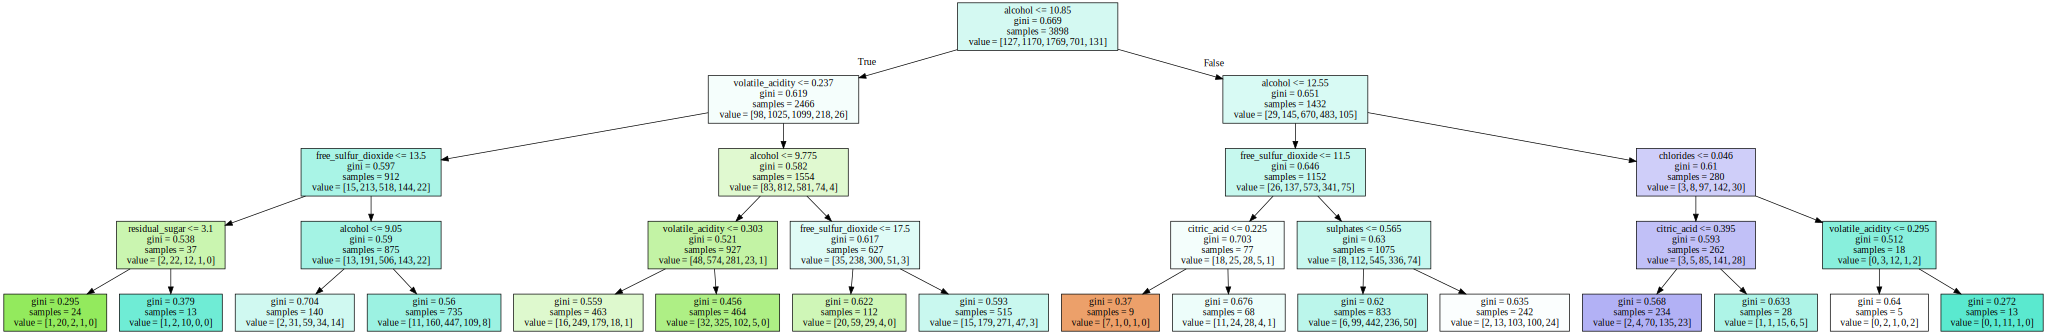

In [ ]:
draw_tree(m, X_test) #hover leaf to see node number

In [ ]:
X_all.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [ ]:
from sklearn.tree import export_text
columnas = [col for col in X_all.columns]# observar en la fila anterior el objeto que recorna X_all.columns
r = export_text(m, feature_names=columnas)

print(r)

print()

print("Las columnas son:", columnas)

|--- alcohol <= 10.85
|   |--- volatile_acidity <= 0.24
|   |   |--- free_sulfur_dioxide <= 13.50
|   |   |   |--- residual_sugar <= 3.10
|   |   |   |   |--- class: 5
|   |   |   |--- residual_sugar >  3.10
|   |   |   |   |--- class: 6
|   |   |--- free_sulfur_dioxide >  13.50
|   |   |   |--- alcohol <= 9.05
|   |   |   |   |--- class: 6
|   |   |   |--- alcohol >  9.05
|   |   |   |   |--- class: 6
|   |--- volatile_acidity >  0.24
|   |   |--- alcohol <= 9.78
|   |   |   |--- volatile_acidity <= 0.30
|   |   |   |   |--- class: 5
|   |   |   |--- volatile_acidity >  0.30
|   |   |   |   |--- class: 5
|   |   |--- alcohol >  9.78
|   |   |   |--- free_sulfur_dioxide <= 17.50
|   |   |   |   |--- class: 5
|   |   |   |--- free_sulfur_dioxide >  17.50
|   |   |   |   |--- class: 6
|--- alcohol >  10.85
|   |--- alcohol <= 12.55
|   |   |--- free_sulfur_dioxide <= 11.50
|   |   |   |--- citric_acid <= 0.23
|   |   |   |   |--- class: 4
|   |   |   |--- citric_acid >  0.23
|   |   |   

¿Cómo se calcula la predicción de una hoja de la fila inferior que contiene más de un valor de la variable target? Se considera que la salida es aquella categoría que tenga la mayor cantidad de elementos, porque es más probable que la muestra pertenezca a dicha categoría.

Ver la ejecución de `y_train.value_counts().sort_index()`, junto con la estructura del árbol exportada en formato de texto (en la celda anterior a esta).

Veamos un ejemplo.

In [ ]:
#@title Hagamos una predicción para la muestra de índice `indicePrueba` { form-width: "300px" }

sample_id = indicePrueba

# Let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = estimator.decision_path(X_test_np)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test_np)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.


node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test_np[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test_np[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test_np[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))
    
print()
print("For the sample %s, the predicted class is %s." % (sample_id, targetPrueba))

# For a group of samples, we have the following common node.
#sample_ids = [0, 1]
#common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) == len(sample_ids))

#common_node_id = np.arange(n_nodes)[common_nodes]

#print("\nThe following samples %s share the node %s in the tree"       % (sample_ids, common_node_id))
#print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

Rules used to predict sample 27: 
decision id node 0 : (X_test_np[27, 10] (= 9.8) <= 10.849999904632568)
decision id node 1 : (X_test_np[27, 1] (= 0.41) > 0.23749999701976776)
decision id node 9 : (X_test_np[27, 10] (= 9.8) > 9.775000095367432)
decision id node 13 : (X_test_np[27, 5] (= 24.0) > 17.5)

For the sample 27, the predicted class is 6.


Verificamos que cumple con la gráfica a colores mostrada, y siguiendo las reglas del árbol exportado como texto.

Se obtuvo **56%** de accuracy en los datos de **train** y **51%** de accuracy en los datos de **validación**. Podremos mejorar esos resultados usando ensamble? Haremos una crossvalidación para dar una mejor respuesta.

## 4) Comparando modelos de predicción

Evaluar el dataset usando crosvalidación para los siguientes algoritmos de clasificación (4 individuales y 4 por ensamble).



    - Logistic Regression (LR)
    - Decision Tree Classifier (DecisionTreeClassifier)
    - K vecinos más cercanos (KNN)
    - Support Vector Machine (SVM)
    - Ensamble AdaBoost para Clasificación (AdaBoostClassifier)
    - Ensamble Gradient Boosting para Clasificación (GradientBoostingClassifier).
    - Ensamble RandomForest para Clasificación (RandomForestClassifier)
    - Ensamble ExtraTrees para Clasificación (ExtraTreesClassifier)



---

 Usar `accuracy` como [métrica de scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

Hacer un pipeline de manera que se realice un escalamiento (`StandardScaler()`) dentro de cada fold.

In [ ]:
### COMPLETE SU CÓDIGO

¿Los resultados usando métodos ensamblados generan una mejora con respecto a los métodos con predictores individuales?

## 5) Optimizar hiperparámetros del mejor algoritmo

Del mejor algoritmo encontrado, elegir uno de sus parámetros. Utilizar `GridSearchCV()` para elegir un valor, y probar una lista con un mínimo de 6 valores que usted coloque.

## 6) Entrenar el modelo final con el algoritmo e hiperparámetros seleccionados, y probarlo en los datos de validación

Genere el reporte de clasificación, e indique textualmente el `f1_score` y el `accuracy` de la predicción.